In [1]:
# Importing the required modules

In [2]:
pip install catboost

     |████████████████████████████████| 76.3 MB 1.4 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [4]:
# Importing the dataset
df = pd.read_csv('Cleaned_Soil.csv')

In [5]:
# Obtaining data specific to Anantapur

In [6]:
df = df[df['District'] == 'Nellore']
df.head()

,Unnamed: 0,Latitude,Longitude,District,Mandal,Village,SoilType,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI,ARVI,EVI,GCI,NDWI,Crop
2119,2122,14.53,80.16,Nellore,Indukurpeta,Gangapatnam,Black,7.75,0.65,1.04,3.18,126.0,1212.0,389.0,45.75,5.02,1.92,24.80,1.64,1.60,0.196903,0.093633,2.144578,0.207589,-0.094034,Paddy
2120,2123,14.53,80.15,Nellore,Indukurpeta,Gangapatnam,Black,7.02,0.56,0.81,2.03,116.0,796.0,313.0,32.27,0.96,1.54,21.10,0.98,0.24,0.233270,0.070684,0.636079,0.658098,-0.247582,Paddy
2121,2124,14.53,80.16,Nellore,Indukurpeta,Gangapatnam,Black,7.50,0.31,0.46,5.17,74.0,662.0,247.0,20.89,1.94,1.84,17.96,0.70,0.38,0.196903,0.093633,2.144578,0.207589,-0.094034,Paddy
2122,2125,14.54,80.16,Nellore,Indukurpeta,Gangapatnam,Black,8.28,0.90,0.65,23.70,106.0,2425.0,422.0,13.88,3.92,1.08,70.68,2.26,5.60,-0.098296,-0.038414,0.492126,-0.395431,0.246440,Paddy
2123,2126,14.54,80.16,Nellore,Indukurpeta,Gangapatnam,Black,8.11,0.96,0.50,15.47,92.0,2264.0,295.0,106.90,5.66,1.25,31.18,1.46,2.78,-0.098296,-0.038414,0.492126,-0.395431,0.246440,Paddy


In [7]:
# Dropping unnecessary columns
df = df.drop(['Unnamed: 0', 'Latitude', 'Longitude', 'District', 'Mandal', 'Village', 'NDVI', 'EVI', 'GCI', 'NDWI'], axis = 1)
df.describe()

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,ARVI
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,7.937333,0.617448,0.598897,12.970276,189.786207,3501.717241,770.052874,93.140805,1.936368,1.536966,39.908828,3.049977,11.783747,0.324401
std,0.680049,0.648608,0.242528,15.480318,139.508957,1677.652106,413.569089,151.978416,2.283530,0.831028,39.992340,2.119376,9.013484,0.182913
min,5.250000,0.060000,0.120000,0.660000,33.000000,237.000000,48.000000,1.880000,0.100000,0.160000,1.040000,0.180000,0.090000,-0.069824
25%,7.780000,0.180000,0.400000,4.845000,112.500000,2339.000000,454.500000,7.520000,0.550000,0.900000,4.485000,1.175000,6.265000,0.199198
50%,8.120000,0.490000,0.570000,8.380000,164.000000,3205.000000,686.000000,55.550000,1.200000,1.390000,29.700000,2.360000,9.130000,0.334649
75%,8.340000,0.815000,0.790000,14.490000,232.500000,4595.000000,1014.000000,121.180000,2.325000,2.035000,65.100000,4.605000,14.690000,0.421952
max,9.330000,7.850000,1.330000,144.750000,2069.000000,9763.000000,1989.000000,2210.320000,23.920000,8.270000,210.830000,9.730000,60.260000,0.769213


In [8]:
# Analysis of SoilType

In [9]:
df.SoilType.unique()

array(['Black', 'Redsoil', ' Black'], dtype=object)

In [10]:
df['SoilType'] = df['SoilType'].replace([' Black', 'Black'], 'Black Soil')
df['SoilType'] = df['SoilType'].replace('Redsoil', 'Red Soil')
df.SoilType.unique()

array(['Black Soil', 'Red Soil'], dtype=object)

In [11]:
soilCount = dict(df['SoilType'].value_counts())
soilCount

{'Black Soil': 326, 'Red Soil': 109}

<BarContainer object of 2 artists>

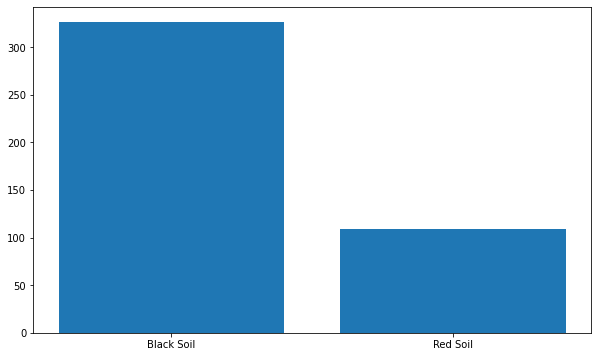

In [12]:
soilType = soilCount.keys()
soilCounts = soilCount.values()
plt.bar(soilType, soilCounts)

In [13]:
# Analysis of Crops grown 

In [14]:
df.Crop.unique()

array(['Paddy', 'Citrus', 'Black gram', 'Green Gram', 'Banana'],
      dtype=object)

In [15]:
df['Crop'].value_counts()

Paddy         267
Citrus        105
Black gram     58
Green Gram      3
Banana          2
Name: Crop, dtype: int64

Paddy         267
Citrus        105
Black gram     58
Name: Crop, dtype: int64


<BarContainer object of 3 artists>

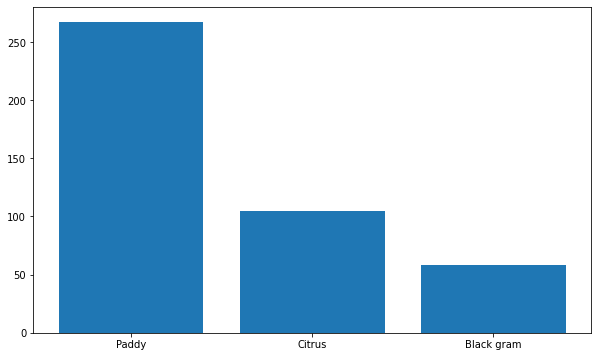

In [16]:
df = df[(df['Crop'] != 'Green Gram') & (df['Crop'] != 'Banana')]

print(df['Crop'].value_counts())
cropCount = dict(df['Crop'].value_counts())
cropType = cropCount.keys()
cropCounts = cropCount.values()
plt.bar(cropType, cropCounts)

In [17]:
# Getting rid of features that have a high correlation among one another

In [18]:
cor_matrix = df.corr()
cor_matrix

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,ARVI
pH,1.000000,-0.108915,-0.399399,-0.099154,0.097205,0.450152,0.122614,-0.138248,-0.318327,-0.213884,-0.667716,-0.310622,-0.358780,0.175854
EC,-0.108915,1.000000,0.331162,0.141713,0.093619,-0.101416,0.231990,0.902309,0.222913,0.649595,0.351346,0.388928,0.225186,-0.069494
OC,-0.399399,0.331162,1.000000,0.290462,0.234016,-0.167425,0.375132,0.275485,0.404378,0.591678,0.577696,0.632627,0.446818,-0.101873
P,-0.099154,0.141713,0.290462,1.000000,0.356177,-0.141434,0.090374,0.056146,0.317506,0.232979,0.111724,0.052044,0.028789,-0.035759
K,0.097205,0.093619,0.234016,0.356177,1.000000,0.140109,0.414285,0.028019,0.053325,0.269589,-0.001686,0.251244,0.210238,-0.017016
Ca,0.450152,-0.101416,-0.167425,-0.141434,0.140109,1.000000,0.451852,-0.034903,-0.279925,-0.038406,-0.395262,-0.094940,-0.029566,0.302848
Mg,0.122614,0.231990,0.375132,0.090374,0.414285,0.451852,1.000000,0.172174,0.005222,0.524759,0.173382,0.595319,0.453250,0.082641
S,-0.138248,0.902309,0.275485,0.056146,0.028019,-0.034903,0.172174,1.000000,0.179381,0.615608,0.297580,0.320158,0.182469,0.001586
Zn,-0.318327,0.222913,0.404378,0.317506,0.053325,-0.279925,0.005222,0.179381,1.000000,0.252096,0.355795,0.277374,0.092095,-0.128934
B,-0.213884,0.649595,0.591678,0.232979,0.269589,-0.038406,0.524759,0.615608,0.252096,1.000000,0.530394,0.633859,0.507055,-0.081037


In [19]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
print('Columns to be dropped : ', to_drop)

Columns to be dropped :  ['S', 'B', 'Fe', 'Cu', 'Mn']


In [20]:
df = df.drop(to_drop, axis = 1)
print('Columns taken into consideration : ', list(df.columns))

Columns taken into consideration :  ['SoilType', 'pH', 'EC', 'OC', 'P', 'K', 'Ca', 'Mg', 'Zn', 'ARVI', 'Crop']


In [21]:
# Separating the dependent and independent variables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [22]:
# Encoding SoilType as it is a categorical variable
X = pd.get_dummies(X, prefix='', prefix_sep='')
print(X.head(1))
print(y.head(1))
X = X.values
y = y.values

        pH    EC    OC     P  ...    Zn      ARVI  Black Soil  Red Soil
2119  7.75  0.65  1.04  3.18  ...  5.02  0.093633           1         0

[1 rows x 11 columns]
2119    Paddy
Name: Crop, dtype: object


In [23]:
# Standardizing the independent variables using Feature Scaling
sc1 = StandardScaler()
X[:, 0:9] = sc1.fit_transform(X[:, 0:9])

In [24]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# K-Nearest Neighbors Classifier

In [25]:
clf1 = KNeighborsClassifier(weights='distance')
clf1.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [26]:
y_test_pred = clf1.predict(X_test)
y_train_pred = clf1.predict(X_train)
AC1_train = accuracy_score(y_train, y_train_pred)
AC1_test = accuracy_score(y_test, y_test_pred)

In [27]:
print('Training Accuracy: ', AC1_train)
print('Testing Accuracy: ', AC1_test)

Training Accuracy:  1.0
Testing Accuracy:  0.8703703703703703


In [28]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf1, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 84.14 %
Standard Deviation: 5.71 %


# Decision Tree Classifier

In [29]:
clf2 = DecisionTreeClassifier(random_state=0)
clf2.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [30]:
y_test_pred = clf2.predict(X_test)
y_train_pred = clf2.predict(X_train)
AC2_train = accuracy_score(y_train, y_train_pred)
AC2_test = accuracy_score(y_test, y_test_pred)

In [31]:
print('Training Accuracy: ', AC2_train)
print('Testing Accuracy: ', AC2_test)

Training Accuracy:  1.0
Testing Accuracy:  0.8240740740740741


In [32]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf2, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 78.87 %
Standard Deviation: 4.62 %


# Random Forest Classifier

In [33]:
clf3 = RandomForestClassifier(random_state=0)
clf3.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [34]:
y_test_pred = clf3.predict(X_test)
y_train_pred = clf3.predict(X_train)
AC3_train = accuracy_score(y_train, y_train_pred)
AC3_test = accuracy_score(y_test, y_test_pred)

In [35]:
print('Training Accuracy: ', AC3_train)
print('Testing Accuracy: ', AC3_test)

Training Accuracy:  1.0
Testing Accuracy:  0.8888888888888888


In [36]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf3, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 87.87 %
Standard Deviation: 5.70 %


In [37]:
# pickle.dump(clf3, open('Nellore_model.pkl', 'wb'))
# pickle.dump(sc1, open('Nellore_scaler.pkl', 'wb'))

# XGBoost

In [38]:
clf4 = HistGradientBoostingClassifier(random_state=0)
clf4.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=0)

In [39]:
y_test_pred = clf4.predict(X_test)
y_train_pred = clf4.predict(X_train)
AC4_train = accuracy_score(y_train, y_train_pred)
AC4_test = accuracy_score(y_test, y_test_pred)

In [40]:
print('Training Accuracy: ', AC4_train)
print('Testing Accuracy: ', AC4_test)

Training Accuracy:  1.0
Testing Accuracy:  0.8796296296296297


In [41]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf4, X = X_train, y = y_train, cv = 10)

In [42]:
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 83.54 %
Standard Deviation: 4.61 %


# Multi-layer Perceptron Classifier

In [43]:
clf5 = MLPClassifier(random_state=0, learning_rate= 'adaptive')
clf5.fit(X_train, y_train)

MLPClassifier(learning_rate='adaptive', random_state=0)

In [44]:
y_test_pred = clf5.predict(X_test)
y_train_pred = clf5.predict(X_train)
AC5_train = accuracy_score(y_train, y_train_pred)
AC5_test = accuracy_score(y_test, y_test_pred)

In [45]:
print('Training Accuracy: ', AC5_train)
print('Testing Accuracy: ', AC5_test)

Training Accuracy:  0.9161490683229814
Testing Accuracy:  0.8796296296296297


In [46]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf5, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 86.96 %
Standard Deviation: 5.36 %


# Catboost

In [47]:
from catboost import CatBoostClassifier, Pool, cv

model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='MultiClass', verbose=True)
model.fit(X_train, y_train)

model.calc_feature_statistics(X_train, y_train, feature=1, plot=True)

train_data = Pool(data=X_train, label=y_train)
model.get_feature_importance(train_data)

#Cross-Validation
cv_dataset = Pool(data=X_train, label=y_train)
params = {"iterations": 100, "depth": 2, "loss_function": "MultiClass", "verbose": False}
scores = cv(cv_dataset, params, fold_count=5, plot="True")

model = CatBoostClassifier(loss_function='MultiClass')
grid = {'learning_rate': [0.03, 0.1], 'depth': [4, 6, 10]}
grid_search_result = model.grid_search(grid, X=X_train, y=y_train, cv=3, plot=True)

model.score(X_test, y_test)

# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

0:	learn: 0.5806178	total: 47.2ms	remaining: 4.67s
1:	learn: 0.4134885	total: 48.6ms	remaining: 2.38s
2:	learn: 0.3956474	total: 49.6ms	remaining: 1.6s
3:	learn: 0.3443414	total: 50.7ms	remaining: 1.22s
4:	learn: 0.3412777	total: 51.7ms	remaining: 983ms
5:	learn: 0.3370235	total: 52.7ms	remaining: 825ms
6:	learn: 0.3338478	total: 53.6ms	remaining: 713ms
7:	learn: 0.3243625	total: 54.6ms	remaining: 628ms
8:	learn: 0.3193464	total: 55.6ms	remaining: 562ms
9:	learn: 0.3119046	total: 56.5ms	remaining: 508ms
10:	learn: 0.3033996	total: 57.5ms	remaining: 465ms
11:	learn: 0.2882015	total: 58.6ms	remaining: 429ms
12:	learn: 0.2841916	total: 59.2ms	remaining: 396ms
13:	learn: 0.2768144	total: 60.2ms	remaining: 370ms
14:	learn: 0.2730721	total: 61.1ms	remaining: 346ms
15:	learn: 0.2628771	total: 62.1ms	remaining: 326ms
16:	learn: 0.2541831	total: 63.1ms	remaining: 308ms
17:	learn: 0.2501893	total: 64.1ms	remaining: 292ms
18:	learn: 0.2480401	total: 65.1ms	remaining: 278ms
19:	learn: 0.2430166	to

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4010458873
bestIteration = 99

Training on fold [1/5]

bestTest = 0.5141469841
bestIteration = 99

Training on fold [2/5]

bestTest = 0.3955420944
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4375015535
bestIteration = 99

Training on fold [4/5]

bestTest = 0.3688525313
bestIteration = 99



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
2:	learn: 0.8438642	total: 5.51ms	remaining: 1.83s
3:	learn: 0.7906751	total: 7.31ms	remaining: 1.82s
4:	learn: 0.7362654	total: 9.08ms	remaining: 1.81s
5:	learn: 0.6883500	total: 10.8ms	remaining: 1.78s
6:	learn: 0.6517501	total: 12.7ms	remaining: 1.8s
7:	learn: 0.6162881	total: 14.5ms	remaining: 1.8s
8:	learn: 0.5822767	total: 16.4ms	remaining: 1.8s
9:	learn: 0.5579302	total: 18.2ms	remaining: 1.8s
10:	learn: 0.5372891	total: 20.2ms	remaining: 1.81s
11:	learn: 0.5161422	total: 22ms	remaining: 1.81s
12:	learn: 0.4925902	total: 23.8ms	remaining: 1.81s
13:	learn: 0.4712948	total: 25.6ms	remaining: 1.8s
14:	learn: 0.4513961	total: 27.5ms	remaining: 1.8s
15:	learn: 0.4338051	total: 29.3ms	remaining: 1.8s
16:	learn: 0.4221964	total: 31.1ms	remaining: 1.8s
17:	learn: 0.4089074	total: 33.1ms	remaining: 1.81s
18:	learn: 0.3985125	total: 35ms	remaining: 1.81s
19:	learn: 0.3872370	total: 36.9ms	remaining: 1.8s
20:	learn: 0.3749462	total: 38.7ms